# <center> Проект: Задача классификации
-------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Первичная обработка данных.

В рамках этой части нам предстоит обработать пропуски и выбросы в данных. Это необходимо для дальнейшей работы с ними.

#### Прочитаем данные.

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Пропуски

Исследуем данные на предмет пропусков. Посмотрим, где есть пропущенные значения и сколько их.

In [4]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Скрытые пропуски

Проверим, есть ли в признаке `job` скрытые пропущенные значения. Возможно, они обозначены каким-то специальным словом.

In [5]:
df.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Cлово, которым закодированы пропуски (неизвестные значения) - *unknown*.

### Преобразование
Преобразуем признак `balance` таким образом, чтобы он корректно считывался, как вещественное число (*float*).

In [6]:
# df['balance'] = df['balance'].apply(lambda x: float(''.join(x.replace(',', '.').split()[:-1])) if type(x) == str else x)
# df['balance'].mean().round(3)

In [7]:
df["balance"] = df["balance"].str.replace(',00', '').str.replace('$', '').str.replace(' ', '')
df['balance'] = df['balance'].astype(float)
print('Среднее значение по признаку balance:')
print(df['balance'].mean().round(3))

Среднее значение по признаку balance:
1529.129


### Обработка пропусков
* В признаке `balance` заменим на медианные значения по данному признаку.
* В категориальных признаках `job` и `education` заменим на модальные значения.

In [8]:
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее значение по признаку balance:')
print(df['balance'].mean().round(3))

df['education'] = df['education'].replace({"unknown" : df.education.mode()[0]})
df['job'] = df['job'].replace({"unknown" : df.job.mode()[0]})

education_mode = df['education'] == df['education'].mode()[0]
job_mode = df['job'] == df['job'].mode()[0]
print('Cредний баланс для клиентов с самой популярной работой и самым популярным уровнем образования:')
print(df['balance'][education_mode & job_mode].mean().round(3))

Среднее значение по признаку balance:
1526.936
Cредний баланс для клиентов с самой популярной работой и самым популярным уровнем образования:
1598.883


### Выбросы

Визуализируем признак `balance`. Прверим на предмет выбросов.

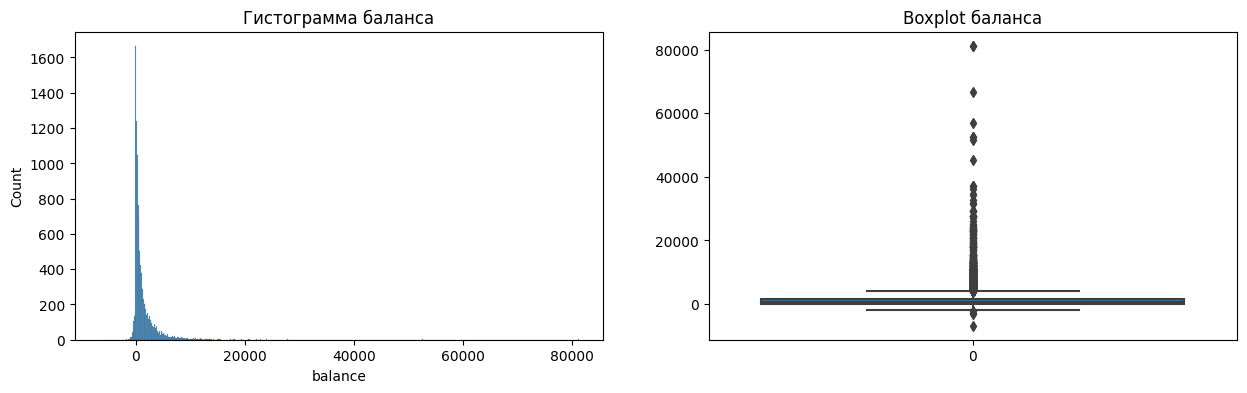

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df['balance'], ax=ax[0]).set_title('Гистограмма баланса')
sns.boxplot(df['balance'],ax=ax[1]).set_title('Boxplot баланса');

### Удаление выбросов признака `balance`.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха ($Q_1 - 1.5 * IQR$) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. ($Q_3 + 1.5 * IQR$). Найдём эти границы, и отфильтруем значения так, чтобы выбросов в данных не осталось.

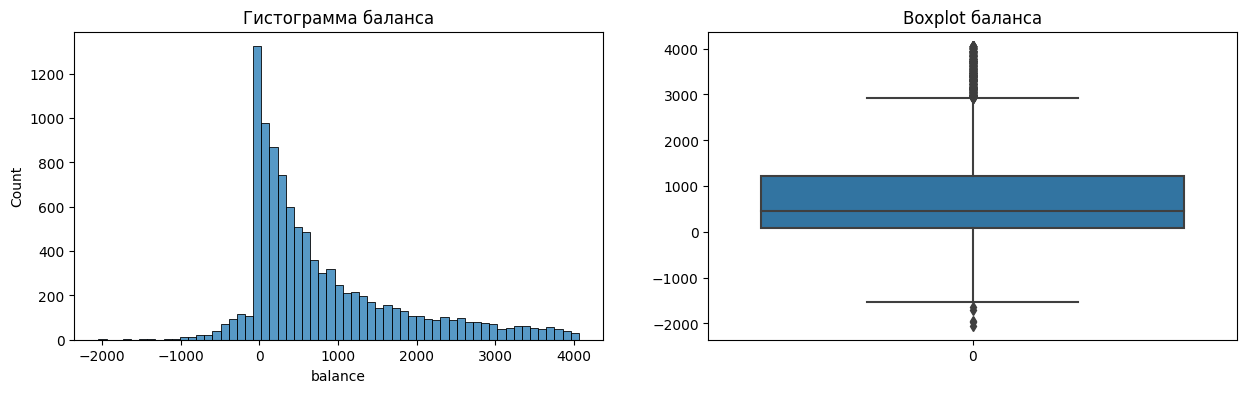

In [10]:
# Функция для нахождения выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    q1 = x.quantile(.25)
    q3 = x.quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr*1.5
    upper_bound = q3 + iqr*1.5
    outliers = data[(x < lower_bound) & (x > upper_bound)]
    data_cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, data_cleaned.reset_index()

outliers, df = outliers_iqr(df, 'balance')

# Визуализация признака после удаления выбросов
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df['balance'], ax=ax[0]).set_title('Гистограмма баланса')
sns.boxplot(df['balance'],ax=ax[1]).set_title('Boxplot баланса');

## Часть 2:  Разведывательный анализ

В данной части проекта нам необходимо будет:

* исследовать данные;

* попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;

* дополнить анализ визуализациями, иллюстрирующими исследование.

### Депозит. Соотношение классов.

Изучим соотношение классов в наших данных на предмет несбалансированности и проиллюстрируем результат.

deposit
yes    0.463
no     0.537
Name: proportion, dtype: float64

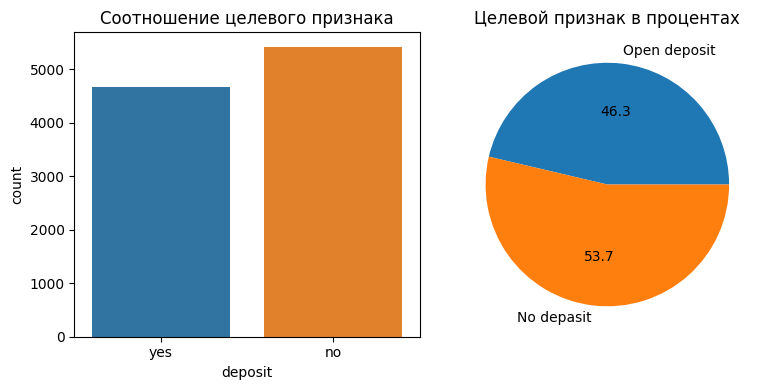

In [11]:
deposit_pie = df['deposit'].value_counts(True, ascending=True)
display(deposit_pie.round(3))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
countplot = sns.countplot(data=df, x='deposit', ax=ax[0])
countplot.set_title('Соотношение целевого признака')
ax[1].pie(deposit_pie, autopct='%.1f', labels=['Open deposit', 'No depasit'])
plt.title('Целевой признак в процентах')
plt.tight_layout()

### Статистика числовых признаков

Рассчитаем описательные статистики для количественных переменных и проинтерпретируем результат.

In [12]:
df.describe()

,index,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,5627.074715,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,3223.261961,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,0.000000,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,2852.000000,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,5684.000000,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,8413.000000,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,11161.000000,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Максимальный возраст слишким высок. Далее можем наблюдать отрицательный баланс.  
Показатель количества пропущенных дней между маркетинговыми кампании также отрицателный.

### Статистика категориальных признаков

Рассчитаем описательные статистики для категориальных переменных. Проинтерпретируем результат, построив визуализацию.

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


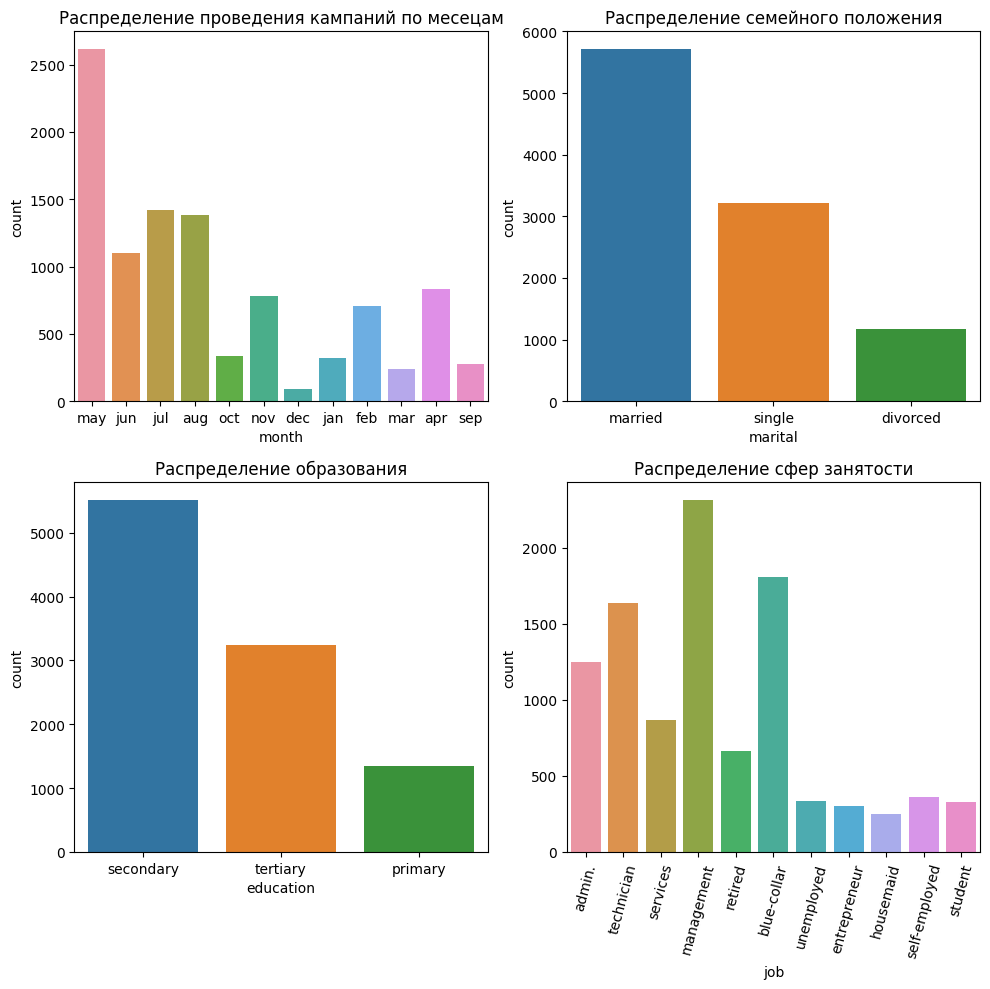

In [13]:
display(df.describe(include=['object']))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.countplot(data=df, x='month', ax=ax[0][0]).set_title('Распределение проведения кампаний по месецам')
sns.countplot(data=df, x='marital', ax=ax[0][1]).set_title('Распределение семейного положения')
sns.countplot(data=df, x='education', ax=ax[1][0]).set_title('Распределение образования')
sns.countplot(data=df, x='job', ax=ax[1][1]).set_title('Распределение сфер занятости')
plt.xticks(rotation=75)
fig.tight_layout()

### Разница результатов кампаний

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


Процентное соотношение сгруппированной таблицы:


deposit,no,yes
poutcome,,
failure,50.7,49.3
other,44.9,55.1
success,8.9,91.1
unknown,60.3,39.7


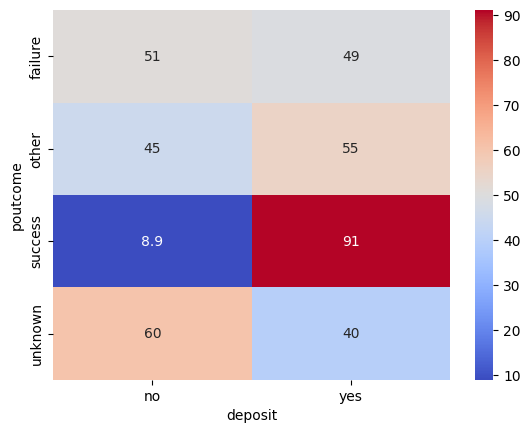

In [14]:
# Группируем по результатам прошлой маркетинговой кампании в рарезе с депозитом.
pivot = df.pivot_table(values='index', index='poutcome', columns='deposit', aggfunc='count')
display(pivot)

print('Процентное соотношение сгруппированной таблицы:')
pivot_prc = pivot.apply(lambda x: x/pivot.sum(axis=1)*100).round(1)
display(pivot_prc)

# Визуализация результата
sns.heatmap(data=pivot_prc, annot=True, cmap='coolwarm');

Для статуса предыдущей маркетинговой компании *success* успех явно преобладает над количеством неудач.

### Результат кампаний в разрезе времени

Теперь узнаем, какова зависимость результата маркетинговых кампаний от месяца и посмотрим в каком месяце чаще всего отказывались от предложения открыть депозит. Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

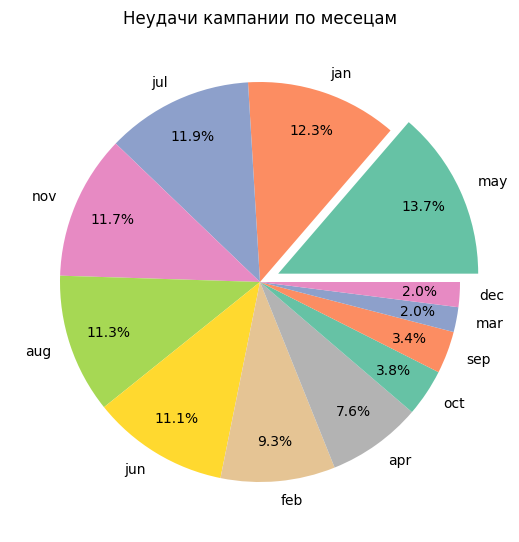

In [15]:
# Группируем данные отказа от депозита по месецам
month_deposit_no = df.groupby('month')['deposit'].value_counts(True)[:,'no'].sort_values(ascending=False).round(2)*100

fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    month_deposit_no,
    explode=[0.1, *np.zeros(11)],
    labels=month_deposit_no.index,
    colors=sns.color_palette('Set2'),
    autopct='%.1f%%',
    pctdistance=0.8,
)
axes.set_title('Неудачи кампании по месецам');

### Депозит от возраста

Посмотрим, люди какого возраста чаще открывают депозиты, а какого — реже. Так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. Поэтому разделим людей по возрастным подгруппам и сделаем выводы уже по ним.

Создадим новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

* `'<30'`;

* `'30-40'`;

* `'40-50'`;

* `'50-60'`;

* `'60+'`.

Это поможет нам определить, в каких группах более склонны открывать депозит, чем отказываться от предложения.

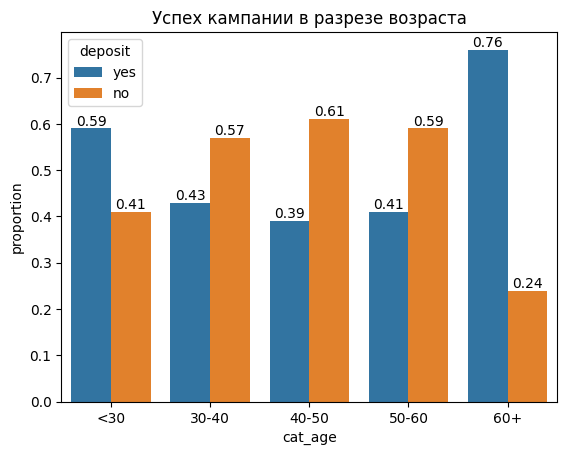

In [16]:
# Списки возрастных категорий для разделения выборки
cat_list = ['<30', '30-40', '40-50', '50-60', '60+']
cat_bins = [0, 29, 39, 49, 59, 100]

# Размечаем признак возраста
df['cat_age'] = pd.cut(df['age'], cat_bins, labels=cat_list)

# Группируем для визуализации
age_dep_bar = df.groupby('cat_age', as_index=False)['deposit'].value_counts(True)

barplot = sns.barplot(data=age_dep_bar.round(2), x='cat_age', y='proportion', hue='deposit')
barplot.bar_label(barplot.containers[0], fontsize=10)
barplot.bar_label(barplot.containers[1], fontsize=10)
barplot.set_title('Успех кампании в разрезе возраста');

### Депозит от категорий клиентов

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;

* уровень образования;

* сфера занятости.

Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше. Ответим на вопросы: к каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?


Для начала построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса в виде двуцветной столбчатой диаграммы.

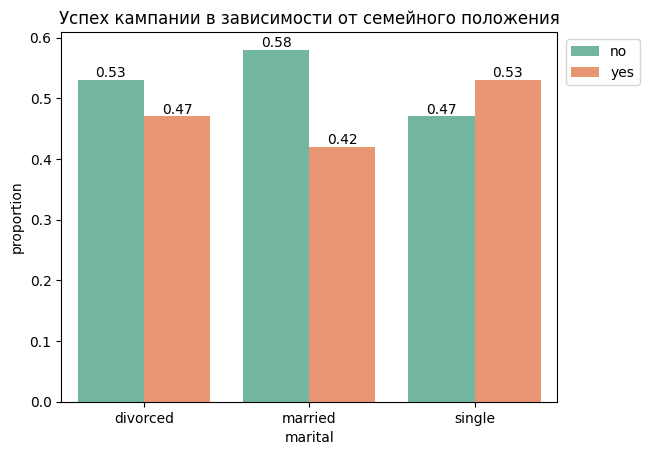

In [17]:
# Группировка данных по семейному статусу для визуализации
marital_dep_bar = df.groupby('marital', as_index=False)['deposit'].value_counts(True)

# Построение диаграммы
barplot = sns.barplot(data=marital_dep_bar.round(2), x='marital', y='proportion', hue='deposit', palette='Set2')
barplot.bar_label(barplot.containers[0], fontsize=10)
barplot.bar_label(barplot.containers[1], fontsize=10)
barplot.legend(bbox_to_anchor=(1.18, 1))
barplot.set_title('Успех кампании в зависимости от семейного положения');

Далее построим визуализацию для открывших и неоткрывших депозит в зависимости от образования.

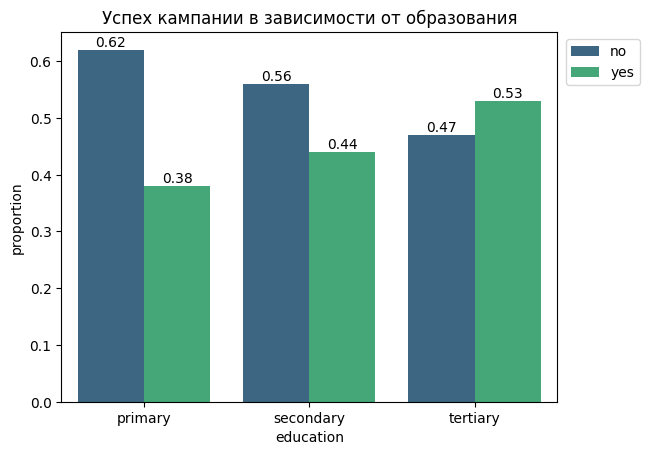

In [18]:
# Группировка данных по уровню образования для визуализации
educ_dep_bar = df.groupby('education', as_index=False)['deposit'].value_counts(True)

# Визуализация
barplot = sns.barplot(data=educ_dep_bar.round(2), x='education', y='proportion', hue='deposit', palette="viridis")
barplot.bar_label(barplot.containers[0], fontsize=10)
barplot.bar_label(barplot.containers[1], fontsize=10)
barplot.legend(bbox_to_anchor=(1.18, 1))
barplot.set_title('Успех кампании в зависимости от образования');

Наконец третий признак. Построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости.

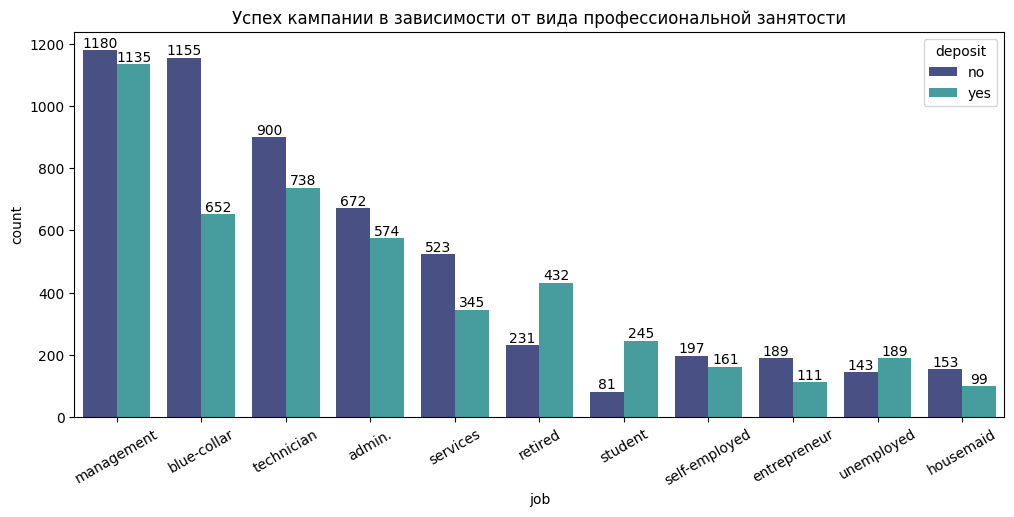

In [19]:
# Группировка данных по по профессиям
job_dep_bar = df.groupby('job', as_index=False)['deposit'].value_counts().sort_values(by='count', ascending=False)

# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
barplot = sns.barplot(data=job_dep_bar.round(2), x='job', y='count', hue='deposit', palette="mako", ax=ax)
barplot.bar_label(barplot.containers[0], fontsize=10)
barplot.bar_label(barplot.containers[1], fontsize=10)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30)
barplot.set_title('Успех кампании в зависимости от вида профессиональной занятости');

### Пересечение категориальных признаков

В предыдущих заданиях мы посмотрели различные категории отдельно. Теперь посмотрим на пересечения категорий. Выявим каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования.

Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построим сводную диаграмму по уровню образования и семейному положению. Представим результаты в виде тепловых карт. Определим, различаются ли наиболее популярные группы для открывших депозит и для неоткрывших. Сделаем вывод, исходя из полученных данных.

Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны (из тех, кто открыл депозит).

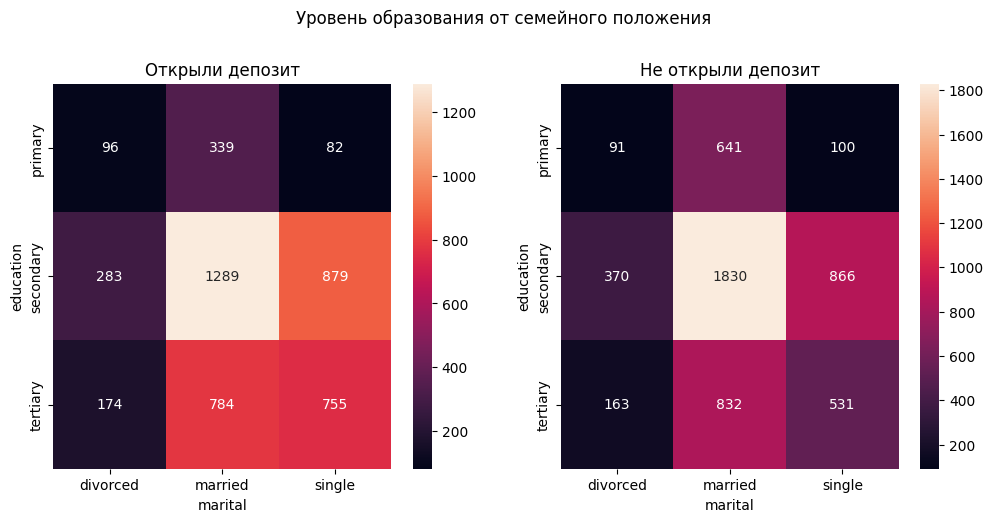

In [20]:
# Разделяем данные
dep_yes = df[df['deposit']=='yes']
dep_no = df[df['deposit']=='no']

# Группируем
heatmap_df_yes = dep_yes.pivot_table('deposit', 'education', 'marital', 'count')
heatmap_df_no = dep_no.pivot_table('deposit', 'education', 'marital', 'count')

# Визуализируем
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(heatmap_df_yes, annot=True, fmt='.0f', ax=ax[0]).set_title('Открыли депозит')
sns.heatmap(heatmap_df_no, annot=True, fmt='.0f', ax=ax[1]).set_title('Не открыли депозит')
fig.text(0.5, 1, 'Уровень образования от семейного положения', fontsize=12, horizontalalignment='center');

Самым многочисленным является пересечение *secondary* и *married*.

## Часть 3: преобразование данных

На этом этапе мы перекодируем и преобразуем данные таким образом, чтобы их можно было использовать при решении задачи классификации. Если на первом этапе мы лишь избавили данные от ненужных артефактов, то на этом шаге совершим действия, более важные для подготовки данных к задаче классификации, уже понимая их структуру.

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

* Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.

* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.

* Надо отобрать признаки, которые мы будем использовать для обучения модели.

### Обработка порядковых признаков

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: `education`. Обработаем его с помощью метода `LabelEncoder`, используя метод без дополнительных настроек.

Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [21]:
# Преобразование уровня образования
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

# Преобразование категорий возраста
df['cat_age'] = le.fit_transform(df['cat_age'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      10105 non-null  int64  
 1   age        10105 non-null  int64  
 2   job        10105 non-null  object 
 3   marital    10105 non-null  object 
 4   education  10105 non-null  int64  
 5   default    10105 non-null  object 
 6   balance    10105 non-null  float64
 7   housing    10105 non-null  object 
 8   loan       10105 non-null  object 
 9   contact    10105 non-null  object 
 10  day        10105 non-null  int64  
 11  month      10105 non-null  object 
 12  duration   10105 non-null  int64  
 13  campaign   10105 non-null  int64  
 14  pdays      10105 non-null  int64  
 15  previous   10105 non-null  int64  
 16  poutcome   10105 non-null  object 
 17  deposit    10105 non-null  object 
 18  cat_age    10105 non-null  int64  
dtypes: float64(1), int64(9), object(9)
memory usag

### Обработка бинарных признаков

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную `deposit` таким образом, чтобы вместо *yes* она принимала значение 1, а вместо *no* — 0.

Сделаем то же самое для других бинарных переменных, которых у нас три: `'default'`, `'housing'`, `'loan'`.

Их мы будем модифицировать по тому же принципу, что и целевую метрику.

In [22]:
# Преобразование бинарных переменных в представление из нулей и единиц
lb = LabelBinarizer()
bin_features = ['deposit', 'default', 'housing', 'loan']
for feature in bin_features:
    df[feature] = lb.fit_transform(df[feature])

# Стандартное отклонение депозита
# print(df.deposit.std().round(3))
# print(df[['default', 'housing', 'loan']].mean().sum().round(3))

### Унитарное кодирование

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

`'job'`, `'marital'`, `'contact'`, `'month'`, `'poutcome'`.

Создадим для них *dummy*-переменные и добавим их в набор данных.

In [23]:
# Создание дамми-переменные
dummy_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df_dummy = pd.get_dummies(df[dummy_features], dtype=int)
df = pd.concat([df, df_dummy], axis=1)

df = df.drop([*dummy_features, 'index'], axis=1)
print('Размерность итоговой выборки:', df.shape)

Размерность итоговой выборки: (10105, 46)


### Корреляция признаков

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого построим матрицу корреляций. Дополним её тепловой картой, отражающей результат.

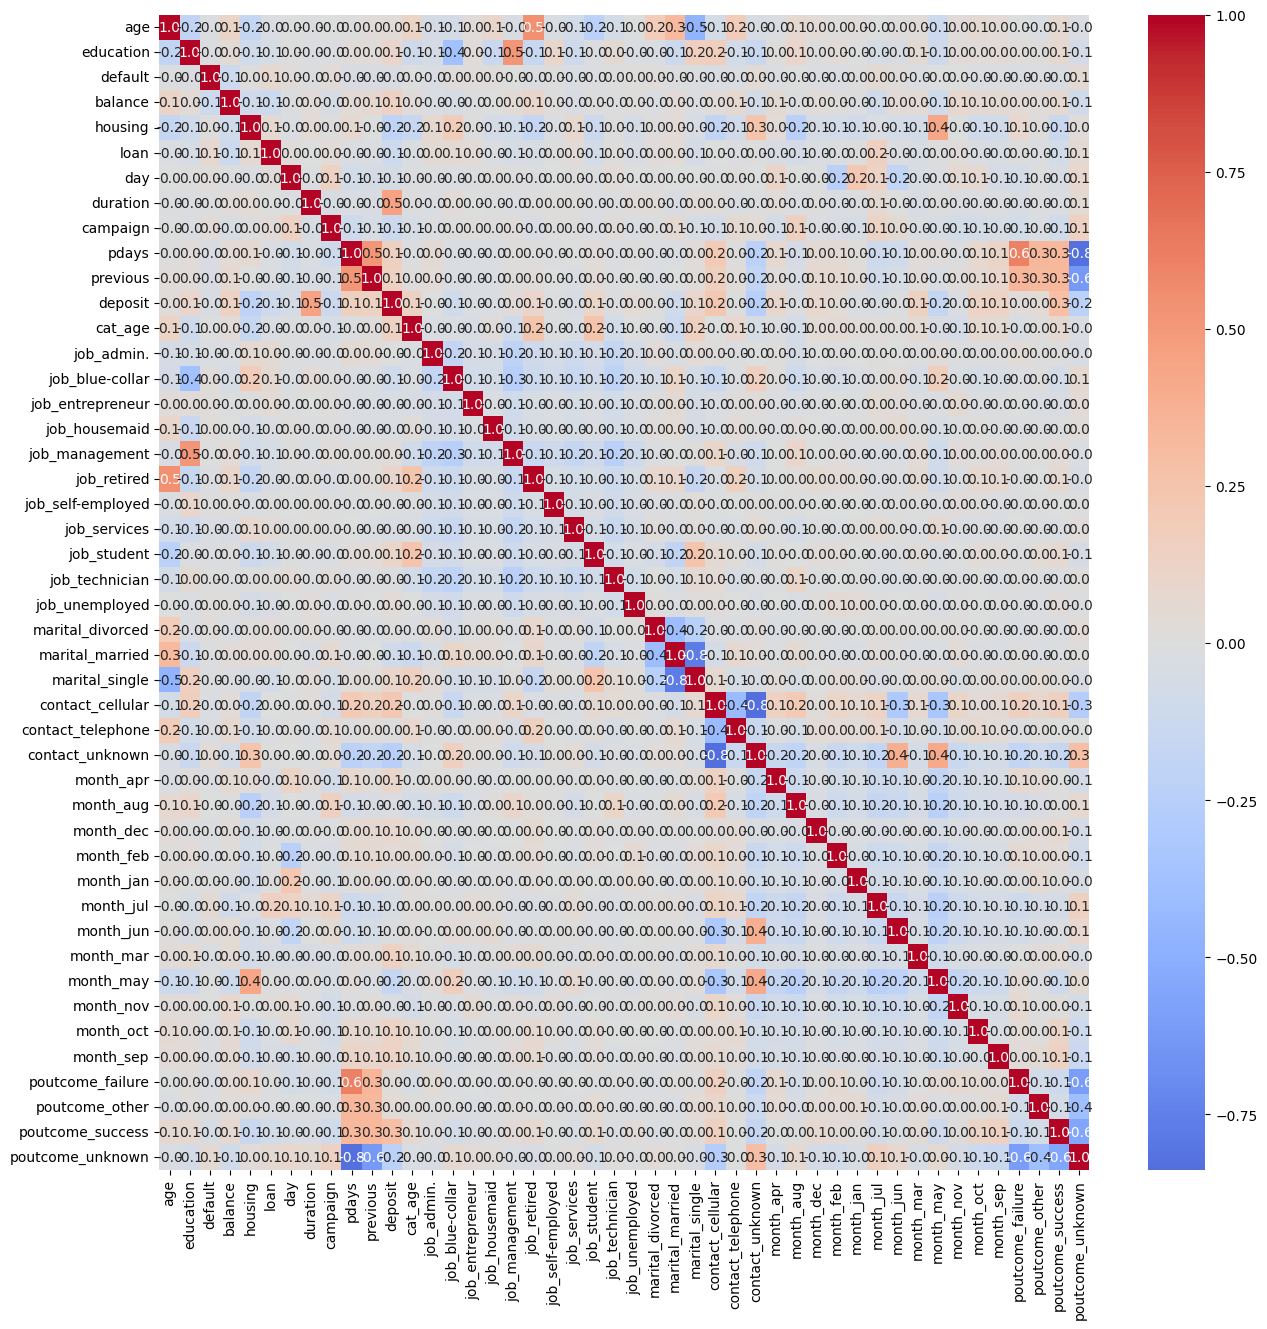

In [25]:
# Матрица корреляций
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=df.corr(), annot=True, fmt='.1f', center=0, cmap= 'coolwarm');

Поскольку получившаяся матрица получилась очень объёмной, мы сократим ёё до размеров сильно скоррелированных признаков.

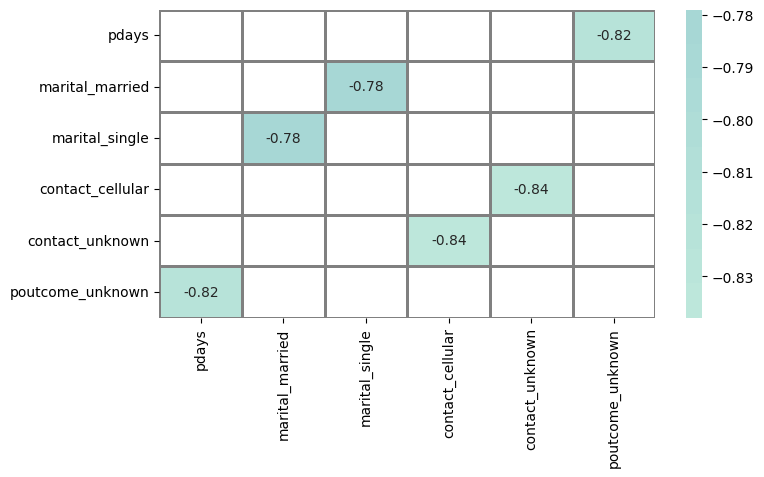

In [26]:
df_corr = df.corr()
df_corr = df_corr[(abs(df_corr)>0.7) & (df_corr < 1)]
df_corr = df_corr.dropna(how='all')
df_corr = df_corr.dropna(how='all', axis=1)

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(data=df_corr, annot=True, fmt='.2f', linewidths=1, linecolor='grey', center=0);

### Разбиение выборки

Теперь необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении зададим параметр `random_state = 42`, а размер тестовой выборки возьмём за 0.33. Также добавим аргумент, определяющий сохранение соотношений целевого признака.

In [28]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер тренировочной выборки: (6770, 45)
Размер тестовой выборки: (3335, 45)


### Отбор признаков

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью `SelectKBest` отберём 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр `score_func = f_classif`.

In [29]:
# Отбор 15 наиболее подходящих признаков
select_kbest = SelectKBest(score_func=f_classif, k=15)
select_array = select_kbest.fit_transform(X_train, y_train)
select_features = select_kbest.get_feature_names_out()
X_train = X_train[select_features]
X_test = X_test[select_features]

### Нормализация

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать *min-max*-нормализацию.

Нормализация требуется для предикторов, а не для целевой переменной.

Нормализуем предикторы в обучающей и тестовой выборках.

In [30]:
# Нормализация данных с помощью minmaxscaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=select_features)
X_test = pd.DataFrame(X_test, columns=select_features)
X_test.iloc[:, 0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

На данном этапе мы построим первую прогностическую модель и оценим её качество. Научимся подбирать оптимальные параметры модели для того, чтобы получить наилучший результат для конкретного алгоритма.

### Логистическая регрессия

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать `'sag'`, в качестве значения параметра `random_state` возьмём число 42 и запустим 1000 итераций. Затем оценим качество модели на тестовой выборке.

In [31]:
# Обучение логистической регрессии и рассчёт метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
print(f"Accuracy: {log_reg.score(X_test, y_test):.2f}")

Accuracy: 0.80


### Деревья решений

Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

`criterion = 'entropy'`; `random_state = 42`.

Остальные параметры оставим по умолчанию.

Затем переберём различные максимальные глубины деревьев и найдем глубину дерева, для которой будет максимальное значение метрики *accuracy*, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [32]:
# обучение решающих деревьев, настройка максимальной глубины
dec_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dec_tree.fit(X_train, y_train)
print(f"Accuracy Train: {dec_tree.score(X_train, y_train):.2f}")
print(f"Accuracy Test: {dec_tree.score(X_test, y_test):.2f}")
print()

# Подбор параметров в ручную
dec_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)
dec_tree.fit(X_train, y_train)
print(f"Accuracy Train: {dec_tree.score(X_train, y_train):.2f}")
print(f"Accuracy Test: {dec_tree.score(X_test, y_test):.2f}")

Accuracy Train: 1.00
Accuracy Test: 0.75

Accuracy Train: 0.82
Accuracy Test: 0.81


### Оптимизация

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуем оптимизацию гиперпараметров с помощью *GridSearch*, перебрав следующие параметры:

`'min_samples_split' : [2, 5, 7, 10]`;

`'max_depth' : [3,5,7]`.

In [33]:
# Подбор оптимальных параметров с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid={
    'min_samples_split' : [2, 5, 7, 10],
    'max_depth' : [3, 5, 7]
}

grid_search = GridSearchCV(dec_tree, param_grid)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print(f"F1 score Test: {metrics.f1_score(y_test, y_pred):.2f}")

F1 score Test: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

На заключительном этапе мы доработаем своё предсказание с использованием более сложных алгоритмов и оценить, с помощью какой модели возможно сделать более качественные прогнозы.

Мы уже смогли обучить несложные модели, и теперь пришло время усложнить их, а также посмотреть, улучшится ли результат (если да, то насколько). Мы обучили решающие деревья, и теперь пришла пора объединить их в случайный лес.

### Случайный лес

Обучим случайный лес со следующими параметрами:

`n_estimators = 100`; `criterion = 'gini'`;

`min_samples_leaf = 5`;

`max_depth = 10`;

`random_state = 42`.

In [34]:
# Обучение случайного леса
random_forest = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print(f'Accuracy Test: {random_forest.score(X_test, y_test):.2f}')
print(f'Recall Test: {metrics.recall_score(y_test, y_pred):.2f}')
print(metrics.classification_report(y_test, y_pred))

Accuracy Test: 0.83
Recall Test: 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Градиентный бустинг

Мы не должены останавливаться на одной модели — необходимо пробовать все доступные варианты. Поэтому теперь сравним полученные результаты с моделью градиентного бустинга. Используем *GradientBoostingClassifier* для решения задачи классификации, задав для него следующие параметры:

`learning_rate = 0.05`;

`n_estimators = 300`;

`min_samples_leaf = 5`;

`max_depth = 5`;

`random_state = 42`.

In [35]:
# Классификация через градиентный бустинг и сравние качества со случайным лесом
grad_boost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
grad_boost.fit(X_train, y_train)
y_pred = grad_boost.predict(X_test)
print(f'F1 score Test: {metrics.f1_score(y_test, y_pred):.2f}')
print(metrics.classification_report(y_test, y_pred))

F1 score Test: 0.82
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Стекинг

Мы попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

Для этого воспользуемся стекингом, объединив те алгоритмы, которые мы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

Параметры оставим те же, что были в наших алгоритмах на предыдущих этапах.

In [36]:
# Объединение известных нам алгоритмы с помощью стекинга
stacking = ensemble.StackingClassifier(
    estimators=[('rf', random_forest), ('gb', grad_boost)],
    final_estimator=log_reg
)
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)
print(f'Precision Test: {metrics.precision_score(y_test, y_pred):.2f}')

Precision Test: 0.81


In [37]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Оценка признаков

Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Оценим, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга.

In [38]:
# Оценка наиболее важных признаков
feature_importance = grad_boost.feature_importances_
importance_df = pd.DataFrame({'features': X_train.columns,
                              'importance': np.round(feature_importance*100, 2)})

importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df

,features,importance
2,duration,50.20
13,poutcome_success,11.63
8,contact_unknown,7.38
0,balance,5.98
4,pdays,5.57
1,housing,4.66
6,cat_age,4.21
9,month_mar,2.61
11,month_oct,1.88
3,campaign,1.71


### Оптимизатор **Optuna**

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи *GridSearch*. Однако мы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк **Optuna**. Применим его для оптимизации гиперпараметров. Для перебора возьмём случайный лес и следующие параметры:

`n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)`;

`max_depth = trial.suggest_int('max_depth', 10, 30, 1)`;

`min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)`.

In [39]:
# Реализация оптимизации гиперпараметров с помощью Optuna
import optuna

# Функция для оптимизации
def optuna_rf(trial):
    n_estimators=trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth=trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    return score

# Обучение оптимизатора
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)

# Вывод результата на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# Обучение модели на лучших параметрах
opt_model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
opt_model.fit(X_train, y_train)
y_pred = opt_model.predict(X_test)

# Вывод результата на тестовой выборке
print(f'F1 score Test: {metrics.f1_score(y_test, y_pred):.2f}')
print(f'Accuracy Test: {opt_model.score(X_test, y_test):.2f}')

[I 2024-02-17 11:00:21,814] A new study created in memory with name: RandomForestClassifier
[I 2024-02-17 11:00:22,243] Trial 0 finished with value: 0.8941434387723144 and parameters: {'n_estimators': 125, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8941434387723144.
[I 2024-02-17 11:00:22,589] Trial 1 finished with value: 0.8693208430913348 and parameters: {'n_estimators': 109, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8941434387723144.
[I 2024-02-17 11:00:23,178] Trial 2 finished with value: 0.8692524241476384 and parameters: {'n_estimators': 188, 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8941434387723144.
[I 2024-02-17 11:00:23,748] Trial 3 finished with value: 0.8940697856360508 and parameters: {'n_estimators': 167, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8941434387723144.
[I 2024-02-17 11:00:24,191] Trial 4 finished with value: 0.8594653743942473 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 128, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
F1 score Test: 0.82
Accuracy Test: 0.83


In [40]:
# Визуализация работы подбора гиперпараметров
print(optuna.visualization.is_available())

optuna.visualization.plot_optimization_history(study, target_name='F1 score')

True


# Итоги

В результате проделанной работы нам удалось решить задачу классификации маркетинговых кампаний, используя разные модели машинного обучения.

Каждый раз мы улучшали показатели метрик, балансируя между смещением и разбросом предсказаний моделей. Для этого мы провели все необходимые этапы подготовки данных, анализа и преобразования.

Методы визуализаций помогли нам наглядным образом оценить статистические показатели данных. Выявить наиболее значимые факторы определяющие точность моделей. И не менее важно, подобрали наилучшие параметры моделий с помощью оптимизации.

Важно пробовать различные методы и способы реализации решения тех или инных задач. Благо инструментов для этого огромное множество. Необходимо проявлять фантазию и креативный подход, тогда совершенствование моделей и улучшение результирующих метрик гарантировано.